We are making clusters out of the embedded data. These clusters represent the data of each individual for categorization purposes

In [17]:
from utils import save_face_list, extract_frames
from face_extraction import process_image, check_face
from facenet_pytorch import MTCNN
import torch
import cv2
from main_unsupervised import find_best_number_of_clusters
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import os
import shutil
import plots
import augmentation
import main_embed
import cluster_dataframe
import embed



In [18]:
MOVIE_TRAINING_LIST = ['New Kids ABC','New Kids Fussballspiel','New Kids Turbo_ Tankstation','New Kids Nitro, _Peter lemonade!_ 720']
MOVIE_TEST_LIST = ['Test']
MOVIE_FOLDER = "C:\\Users\\ningw\\Desktop\\"

FACES_FOLDER_TRAINING = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\face_folder\\'
FACES_FOLDER_TEST = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\face_folder_test\\'

OUTPUT_FOLDER_RESULTS_TRAIN = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\results\\'
RESULTS_NAME_TRAIN = 'second_results.csv'
RESULTS_CSV_TRAIN = 'results\\second_results.csv'

OUTPUT_FOLDER_RESULTS_TEST = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\results_test\\'
RESULTS_NAME_TEST = 'test_results.csv'
RESULTS_CSV_TEST = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\results_test\\test_results.csv'

KMEANS_OUTPUT_FOLDER = 'KMEANS_OUTPUT'
CLUSTER_MODEL_PATH = 'C:\\Users\\ningw\\Desktop\\Assignment 3\\KTA3\\KMEANS_OUTPUT\\kmeans.pkl'

directories = [MOVIE_FOLDER,FACES_FOLDER_TRAINING,FACES_FOLDER_TEST,OUTPUT_FOLDER_RESULTS_TRAIN,OUTPUT_FOLDER_RESULTS_TEST,KMEANS_OUTPUT_FOLDER]
for path in directories:
    if not os.path.isdir(path):
        os.makedirs(path, exist_ok=True)
        print(f"Checked/Created directory: {path}")
    else: 
        print(f"Directory already exists: {path}")


Directory already exists: C:\Users\ningw\Desktop\
Directory already exists: C:\Users\ningw\Desktop\Assignment 3\KTA3\face_folder\
Directory already exists: C:\Users\ningw\Desktop\Assignment 3\KTA3\face_folder_test\
Directory already exists: C:\Users\ningw\Desktop\Assignment 3\KTA3\results\
Directory already exists: C:\Users\ningw\Desktop\Assignment 3\KTA3\results_test\
Directory already exists: KMEANS_OUTPUT


In [19]:

cap = cv2.VideoCapture(MOVIE_FOLDER+MOVIE_TRAINING_LIST[1]+'.mp4')
if not cap.isOpened():
    print("Error: Cannot open video file.")
else:
    print("Video file opened successfully!")
cap.release()


Video file opened successfully!


In [20]:
from main_extract_faces import process_movies

# Define parameters
MOVIE_FOLDER = 'C:\\Users\\ningw\\'
FACES_FOLDER_TRAINING = 'D:\\KTAI\\assignments\\3\\repo\\face_folder\\'
MOVIE_TRAINING_LIST = ['New Kids ABC', 'New Kids Fussballspiel', 'New Kids Turbo_ Tankstation']

input_extension = '.mp4'
output_extension = '.png'
samples_per_second = 10
padding_x = 10
padding_y = 10
min_confidence = 0.5

# Call the function using the defined variables
process_movies(
    movie_list=MOVIE_TRAINING_LIST,
    movie_folder=MOVIE_FOLDER,
    faces_folder=FACES_FOLDER_TRAINING,
    input_extension=input_extension,
    output_extension=output_extension,
    samples_per_second=samples_per_second,
    padding_x=padding_x,
    padding_y=padding_y,
    min_confidence=min_confidence
)


Processing: New Kids ABC.mp4
Start extracting frames
Error: Cannot open video file.
Saving faces...
Processing: New Kids Fussballspiel.mp4
Start extracting frames
Error: Cannot open video file.
Saving faces...
Processing: New Kids Turbo_ Tankstation.mp4
Start extracting frames
Error: Cannot open video file.
Saving faces...


In [21]:
main_embed.embed(FACES_FOLDER_TRAINING, OUTPUT_FOLDER_RESULTS_TRAIN,RESULTS_NAME_TRAIN)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:\\KTAI\\assignments\\3\\repo\\face_folder'

In [ ]:
best_clusters_silhouette, best_clusters_calinski = find_best_number_of_clusters(RESULTS_CSV_TRAIN)
cluster_choice = best_clusters_calinski


In [ ]:
# Define parameters
MOVIE_FOLDER = 'C:\\Users\\ningw'
FACES_FOLDER_TEST = 'D:\\KTAI\\assignments\\3\\repo\\face_folder_test\\'
MOVIE_TEST_LIST = ['Test']

input_extension = '.mp4'
output_extension = '.png'
samples_per_second = 10
padding_x = 10
padding_y = 10
min_confidence = 0.5

# Function call for testing movies
process_movies(
    movie_list=MOVIE_TEST_LIST,
    movie_folder=MOVIE_FOLDER,
    faces_folder=FACES_FOLDER_TEST,
    input_extension=input_extension,
    output_extension=output_extension,
    samples_per_second=samples_per_second,
    padding_x=padding_x,
    padding_y=padding_y,
    min_confidence=min_confidence
)


In [ ]:
main_embed.embed(FACES_FOLDER_TEST,OUTPUT_FOLDER_RESULTS_TEST,RESULTS_NAME_TEST)


In [ ]:

train_embeddings_df = pd.read_csv(RESULTS_CSV_TRAIN)
trains_embeddings = train_embeddings_df.T.values
test_embeddings_df = pd.read_csv(RESULTS_CSV_TEST)
test_embeddings = test_embeddings_df.T.values

kmeans = KMeans(random_state=0, n_clusters=cluster_choice).fit(trains_embeddings)
labels = kmeans.labels_

distances_train = pairwise_distances_argmin_min(trains_embeddings, kmeans.cluster_centers_)[1]
threshold_distance_85 = np.percentile(distances_train, 85)

plots.plot_histplot_percentile(distances_train, threshold_distance_85)

for i, file_name in enumerate(train_embeddings_df.columns):
    if distances_train[i] > threshold_distance_85:
        train_embeddings_df.drop(file_name, axis='columns', inplace=True)
    
trains_embeddings = train_embeddings_df.T.values
kmeans = KMeans(random_state=0, n_clusters=cluster_choice, max_iter=600).fit(trains_embeddings)
labels = kmeans.labels_

for i, file_name in enumerate(train_embeddings_df.columns):
    src_path = os.path.join(FACES_FOLDER_TRAINING, file_name)
    if distances_train[i] > threshold_distance_85:
        dst_path = os.path.join(KMEANS_OUTPUT_FOLDER, 'outliers', file_name)
    else:   
        dst_path = os.path.join(KMEANS_OUTPUT_FOLDER, f'cluster_{labels[i]}', file_name)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    shutil.copy(src_path, dst_path)
    


Processing Test.mp4
Start extracting frames
Successfully captured 521 frames


I0000 00:00:1744314362.287367  178957 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
W0000 00:00:1744314362.290377  207784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1744314362.294646  178957 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
W0000 00:00:1744314362.295898  207793 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1744314362.299900  178957 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3 Pro
W0000 00:00:1744314362.300790  207804 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1744314362.304494  178957 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: App

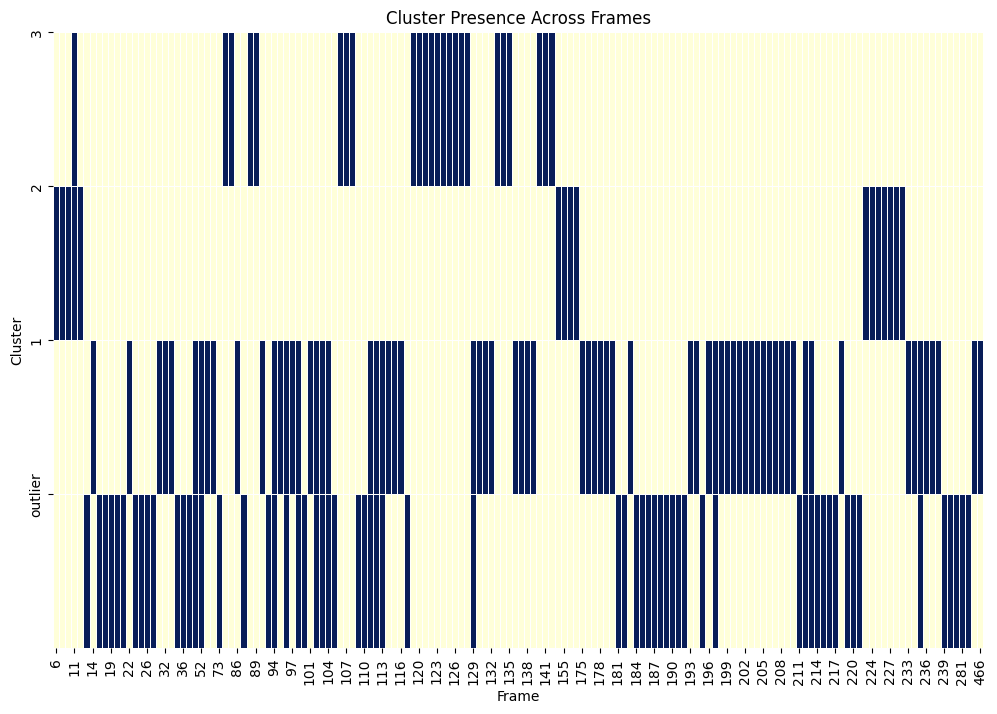

In [ ]:
thresholds = [0.80, 0.85, 0.9, 0.95]
for threshold in thresholds:
    # Calculate the threshold distance for the current percentile
    threshold_distance = np.percentile(distances_train, threshold * 100)      
    clusterdf = cluster_dataframe.process_videos_to_dataframe(MOVIE_TEST_LIST,MOVIE_FOLDER,kmeans, threshold_distance_85=threshold_distance)
    plots.plot_cluster_presence(clusterdf.sort_index(ascending=False)) 


In [ ]:
#Maakt de augmentations
augmentation.process_images_with_augmentations(FACES_FOLDER_TEST,'AUGMENTED')


In [ ]:
#Maakt van iedere folder met augmentation nieuwe embeddings
for folder_name in os.listdir('AUGMENTED'):
    folder_path = os.path.join('AUGMENTED', folder_name,'')
    if os.path.isdir(folder_path):
        # Dynamically construct paths
        AUGMENTED_FOLDERS = folder_path
        RESULT_NAME_TRAIN = f'embed_{folder_name}.csv'

        # Print paths for debugging
        print(f"Processing folder: {AUGMENTED_FOLDERS}")
        print(f"Output folder: {OUTPUT_FOLDER_RESULTS_TEST}")
        print(f"Result file: {RESULT_NAME_TRAIN}")

        # Call embedding function (example)
        main_embed.embed(AUGMENTED_FOLDERS, OUTPUT_FOLDER_RESULTS_TEST, RESULT_NAME_TRAIN)


In [ ]:
thresholds = [0.80, 0.85, 0.9, 0.95]
for threshold in thresholds:
    # Calculate the threshold distance for the current percentile
    threshold_distance = np.percentile(distances_train, threshold * 100)
    
    # Process the test embeddings with the current threshold
    results_df = cluster_dataframe.process_test_embeddings(
        test_embeddings=test_embeddings,
        test_embeddings_df=test_embeddings_df,
        kmeans=kmeans,
        output_folder='recognition-output',
        face_folder_test='face_folder_test',
        threshold=threshold_distance,
        results_output_path = f'test_results_{threshold}.csv',
        
    )
    
    # Plot actor presence
    plots.plot_actor_presence(results_df, 'Cluster', cluster_choice,f'test_results_{threshold}.csv')


In [ ]:
#voor ieder embeddingbestand wordt clusterin gedaan, afstand bepaald en frequenty gedemonstreerd clustering distance 85
for file_name in os.listdir(OUTPUT_FOLDER_RESULTS_TEST):
    file_path = os.path.join(OUTPUT_FOLDER_RESULTS_TEST, file_name)
    
    # Check if it's a CSV file
    if file_name.endswith('.csv') and os.path.isfile(file_path):
        print(f"Processing file: {file_name}")
        
        # Read the embeddings from the CSV file
        test_embeddings_df = pd.read_csv(file_path)
        test_embeddings = test_embeddings_df.T.values
        print(test_embeddings_df.columns)
        # Process the embeddings and generate results
        results_df = cluster_dataframe.process_test_embeddings(
            test_embeddings=test_embeddings,
            test_embeddings_df=test_embeddings_df,
            kmeans=kmeans,
            output_folder='recognition-output',
            face_folder_test='face_folder_test',
            threshold=threshold_distance_85,
            results_output_path = file_name,
            
            
        )
        
        # Plot actor presence
        plots.plot_actor_presence(results_df, 'Cluster', cluster_choice,file_name)